# Introduction to Convnets
Haohang Li  
09/29/2021

This notebook modified bases on  Chapter 5, Section 1 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff).

### Dependencies

In [ ]:
! pip install torchinfo

In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, Dataset
from torchinfo import summary

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Some Loss Functions & Activation Functions

## Loss Functions

### Regresssion Problem:


*   Mean Squared Error(MSE): Pytorch Function: [nn.MSELoss](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html#torch.nn.MSELoss) or [mse_loss](https://pytorch.org/docs/stable/generated/torch.nn.functional.mse_loss.html#torch.nn.functional.mse_loss) (Function)

    $$L = (y - \hat{y})^2$$

*   Mean Absolute Error(MAE): Pytorch Function: [nn.L1Loss](https://pytorch.org/docs/stable/generated/torch.nn.L1Loss.html#torch.nn.L1Loss) or [l1_loss](https://pytorch.org/docs/stable/generated/torch.nn.functional.l1_loss.html#torch.nn.functional.l1_loss) (Function)

$$L = |y - \hat{y}|$$



### Classification Problem:

*   Bianry Cross Entropy(BCE): Pytorch Function: [nn.BCEWithLogitsLoss](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html#torch.nn.BCEWithLogitsLoss) or [binary_cross_entropy_with_logits](https://pytorch.org/docs/stable/generated/torch.nn.functional.binary_cross_entropy_with_logits.html#torch.nn.functional.binary_cross_entropy_with_logits) (Function) (Contain a logistic activation function)

    $$L = -y log(\hat{y}) - (1 - y) (log(1 - \hat{y}))$$

*   Cross Entropy: Pytorch Function: [nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss) or [cross_entropy](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html#torch.nn.functional.cross_entropy)  (Function) (Contain a softmax function)

$$L(x, class) = -log(\frac{exp(x[class])}{\sum_j exp(x[j])})$$

  1.   Softmax() function has been inclued in the loss function

  2.   The CrossEntropy loss takes two inputs: Model Outputs(batch_size, num_class) and Targe(batch_size,). We don't need to apply one-hot encoding on the Target, Pytorch will take care this for us.
  3. Example: 
  $$L([1,2,3], 2)=-log(\frac{exp(3)}{exp(1) + exp(2) + exp(3)})$$
  $$=-log(0.6652)$$
  $$=0.4076$$



In [ ]:
# yhat 
#     output
#         binary : 1 unit 
#         (64,1) to (64,) -> view(-1) -> flatten matrix into vector 

# different loss function requires requires different shapes 
# bce -> yhat needs to be vector

# target: long 

## Activation Function:



*   Sigmoid:  Convert an output to a probility bounded within (0, 1)

$$S(x) = \frac{1}{1 + e^{-x}}$$

*   Softmax: Normalize the output to a probability distribution over predicted output classes

$$\sigma(z_i) = \frac{e^{z_i}}{\sum^{K}_{j=1} e^{z_j}}$$



## Simple Convolutional Neural Network Model

First, let's take a practical look at a very simple convnet example. We will use our convnet to classify MNIST digits using a densely-connected network. Even though our convnet will be very basic, its 
accuracy will still blow out of the water that of the densely-connected model from Chapter previous lab.

The following code below show you what a basic convnet looks like. It's a stack of `Conv2D` and `MaxPooling2D` layers. We'll see in a 
minute what they do concretely.
Importantly, a convnet takes as input tensors of shape `(image_channels, image_height, image_width)` (not including the batch dimension). 
In our case, we will configure our convnet to process inputs of size `(1, 28, 28)`, which is the format of MNIST images.

CNN Ouput shape formula:  
 1. For square output: 


   *   If we have padding:
       $$O = \frac{n - f + 2p}{s} + 1$$

   *   if we don't have padding:
       $$O = \frac{n - f}{s} + 1$$

 Assume we have $n \times n$ input, $f \times f$ filter, padding of $p$ and stride of $s$.

   2. For non square output:

   *   If we have padding:

       $$O_h = \frac{n_h - f_h + 2p} {s} + 1$$

       $$O_w = \frac{n_w - f_w + 2p} {s} + 1$$

   *   If we don't have padding:

       $$O_h = \frac{n_h - f_h} {s} + 1$$

       $$O_w = \frac{n_w - f_w } {s} + 1$$

 Assume we have $n_h \times n_w$ input, $f_h \times f_w$, padding of $p$ and stride of $s$.

Build a simple conv net:

In [ ]:
class SimpleConvnet(nn.Module):
    def __init__(self):
        super(SimpleConvnet, self).__init__()
        # conv net
        self.convnet = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3),  # (32, 26, 26)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),  #(32, 13, 13)  if stride is not provided, it will default to kernel_size

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),  # (64, 11, 11),  param = (3*3*32+1)*64
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),  # (64, 5, 5)
            
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3),  # (64, 3, 3)
            nn.Flatten() # 64*3*3 features after flattening 
        )
        # classifier
        self.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(in_features=576, out_features=64),  # 576 = 64 * 3 * 3
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=10)
        )
    def forward(self, x):
        x = self.convnet(x)
        x = self.classifier(x)

        return x


In [ ]:
# nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3), out_channels-> number of filter 


Let's display the architecture of our convnet so far:

In [ ]:
visual_model = SimpleConvnet()
summary(visual_model, (10, 1, 28, 28)) # sample of input : 10 feature, 1 channel, kernel size (use large for hw)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Layer (type:depth-idx)                   Output Shape              Param #
SimpleConvnet                            --                        --
├─Sequential: 1-1                        [10, 576]                 --
│    └─Conv2d: 2-1                       [10, 32, 26, 26]          320
│    └─ReLU: 2-2                         [10, 32, 26, 26]          --
│    └─MaxPool2d: 2-3                    [10, 32, 13, 13]          --
│    └─Conv2d: 2-4                       [10, 64, 11, 11]          18,496
│    └─ReLU: 2-5                         [10, 64, 11, 11]          --
│    └─MaxPool2d: 2-6                    [10, 64, 5, 5]            --
│    └─Conv2d: 2-7                       [10, 64, 3, 3]            36,928
│    └─Flatten: 2-8                      [10, 576]                 --
├─Sequential: 1-2                        [10, 10]                  --
│    └─Dropout: 2-9                      [10, 576]                 --
│    └─Linear: 2-10                      [10, 64]                  36,928
│ 

## Load MINST Dataset

In [ ]:
# load from torch vision package
train_dataset = torchvision.datasets.MNIST('./data',
                                           train=True,
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.MNIST('./data',
                                          train=False,
                                          transform=transforms.ToTensor(),
                                          download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=32,
                          shuffle=True)
valid_loader = DataLoader(dataset=test_dataset,
                          batch_size=32,
                          shuffle=False)

## Train function

In [ ]:
# don't use softmax 
# apply maz only if you have to convert prob to class 

def train(batch_size, num_epochs, learning_rate, model, train_loader, valid_loader, device):
  # move the model to device
  model = model.to(device)  # move the model to gpu or cpu

  # history
  history = {'train_loss': [],
             'train_acc': [],
             'valid_loss': [],
             'valid_acc': []}

  # set up loss function and optimizer
  criterion = nn.CrossEntropyLoss()  # the CrossEntropyLoss() will provide the softmax for us
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  # pass in the parameters to be updated and learning rate

  # traning loop
  print('Training Starts:')
  num_total_steps = len(train_loader)
  for epoch in range(num_epochs):
      model.train()  # start to train the model, activate training behavior
      train_loss = 0
      train_acc = 0
      for i, (images, labels) in enumerate(train_loader):
          # reshape images
          images = images.to(device)  # reshape: from (128, 1, 28, 28) -> (128, 28 * 28) = (128, 284), move batch to device
          labels = labels.to(device)  # move to device
          # forward
          outputs = model(images)  # forward
          cur_train_loss = criterion(outputs, labels)  # loss
          # backward
          cur_train_loss.backward()  # run back propagation
          optimizer.step()  # optimizer update all model parameters
          optimizer.zero_grad()  # set gradient to zero, avoid gradient accumulating
          # loss
          train_loss += cur_train_loss
          # acc
          _, pred_class = torch.max(outputs, 1)
          train_acc += (pred_class == labels).sum().item() / batch_size

      # valid
      model.eval()  # start to train the model, activate training behavior
      with torch.no_grad():  # tell pytorch not to update parameters
          val_loss = 0
          val_acc = 0
          for images, labels in valid_loader:
              # calculate validation loss
              images = images.to(device)
              labels = labels.to(device)
              outputs = model(images)
              cur_valid_loss = criterion(outputs, labels)
              val_loss += cur_valid_loss
              _, pred_class = torch.max(outputs, 1)
              val_acc += (pred_class == labels).sum().item() / batch_size
      
      # print & record
      train_loss = train_loss / len(train_loader)
      train_acc = train_acc / len(train_loader)
      val_loss = val_loss / len(valid_loader)
      val_acc = val_acc / len(valid_loader)
      print(f"Epoch:{epoch + 1} / {num_epochs}, train loss:{train_loss:.5f}, train acc: {train_acc:.5f}, valid loss:{val_loss:.5f}, valid acc:{val_acc:.5f}")
      history['train_loss'].append(train_loss)
      history['train_acc'].append(train_acc)
      history['valid_loss'].append(val_loss)
      history['valid_acc'].append(val_acc)

  return history


## Train the model

In [ ]:
model = SimpleConvnet()

history = train(batch_size=32,
                num_epochs=10,
                learning_rate=0.005,
                model=model,
                train_loader=train_loader,
                valid_loader=valid_loader,
                device=device)

Training Starts:
Epoch:1 / 10, train loss:0.15744, train acc: 0.95133, valid loss:0.06676, valid acc:0.97853
Epoch:2 / 10, train loss:0.09849, train acc: 0.97238, valid loss:0.07955, valid acc:0.97594
Epoch:3 / 10, train loss:0.09339, train acc: 0.97387, valid loss:0.05958, valid acc:0.98043
Epoch:4 / 10, train loss:0.09320, train acc: 0.97477, valid loss:0.07633, valid acc:0.97873
Epoch:5 / 10, train loss:0.09686, train acc: 0.97492, valid loss:0.06829, valid acc:0.98143
Epoch:6 / 10, train loss:0.08741, train acc: 0.97798, valid loss:0.08574, valid acc:0.97504
Epoch:7 / 10, train loss:0.08959, train acc: 0.97730, valid loss:0.05681, valid acc:0.98313
Epoch:8 / 10, train loss:0.08855, train acc: 0.97778, valid loss:0.08721, valid acc:0.97943
Epoch:9 / 10, train loss:0.08796, train acc: 0.97857, valid loss:0.07152, valid acc:0.97973
Epoch:10 / 10, train loss:0.09128, train acc: 0.97772, valid loss:0.08591, valid acc:0.97694


## Plot

<function matplotlib.pyplot.plot>

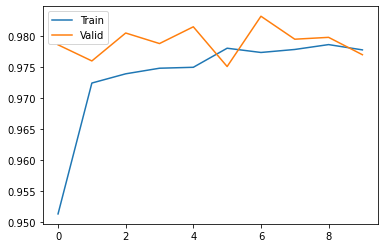

In [ ]:
plt.plot(history['train_acc'], label='Train')
plt.plot(history['valid_acc'], label='Valid')
plt.legend()
plt.plot

<function matplotlib.pyplot.plot>

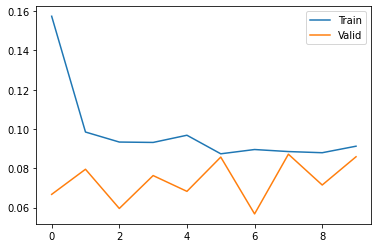

In [ ]:
plt.plot(history['train_loss'], label='Train')
plt.plot(history['valid_loss'], label='Valid')
plt.legend()
plt.plot